The goal of this notebook is to check that the IAS solution recovers the same as the L1-regularized solution, in a certain limit.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import jlinops
import sampi

# Toy problem

In [2]:
ground_truth = jlinops.piecewise_constant_1d_test_problem()
n = len(ground_truth)
np.random.seed(0)
noise_stdev = 0.05
noise_var = noise_stdev**2
noisy_signal = ground_truth + noise_stdev*np.random.normal(size=n)
grid = np.arange(n)

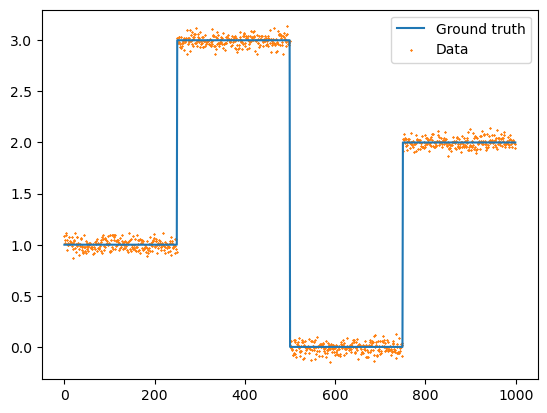

In [3]:
plt.plot(grid, ground_truth, label="Ground truth", color="C0")
plt.scatter(grid, noisy_signal, marker="x", label="Data", color="C1", alpha=1.0, s=0.5)
plt.legend()
plt.show()

Set regularization parameter

In [4]:
reg_lambda = 1e2

# Do reconstruction of original L1-regularized problem

In [5]:
# Solution is given by evaluating the proximal operator of the TV norm. This code uses a FDGP method
fdgp_map_result, fdgp_data = jlinops.prox_tv1d_norm(noisy_signal, lam=noise_var*reg_lambda, iterations=100000, return_data=True)

KeyboardInterrupt: 

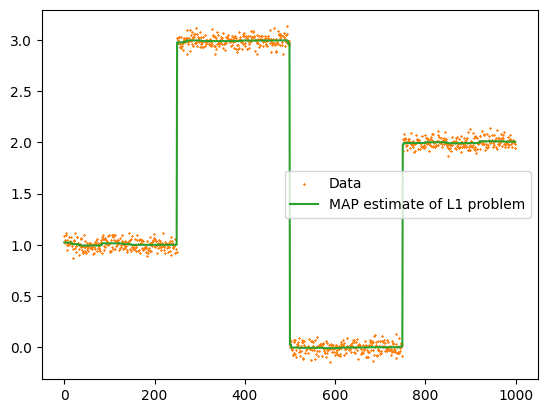

In [35]:
plt.scatter(grid, noisy_signal, marker="x", label="Data", color="C1", alpha=1.0, s=0.5)
plt.plot(grid, fdgp_map_result, label="MAP estimate of L1 problem", color="C2")
plt.legend()
plt.show()

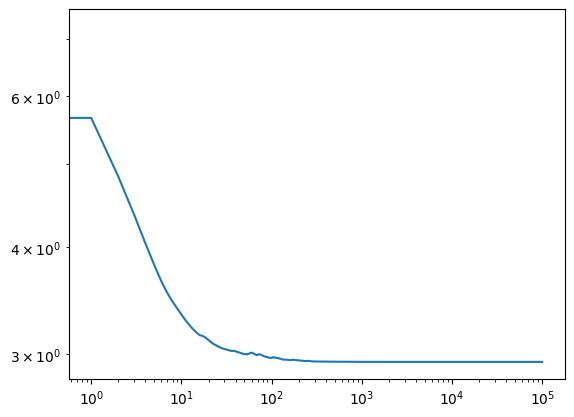

In [36]:
# Check convergence
plt.loglog(fdgp_data["obj_vals"])
plt.show()

# Reconstruction by IAS

In [37]:
# Define forward operator and regularization matrix
F = jlinops.IdentityOperator((n,n))
R, W = jlinops.first_order_derivative_1d(n, boundary="none")
W = jlinops.MatrixLinearOperator(W)
R = jlinops.MatrixLinearOperator(R)

In [38]:
hyperparams = {
}

_Rpinv = jlinops.MatrixLinearOperator(np.linalg.pinv(R.A.toarray()))
Rpinv_factory = lambda theta: _Rpinv @ jlinops.DiagonalOperator(np.sqrt(theta))

pdata = {
    "W": W,
    "Rpinv_factory": Rpinv_factory,
}

In [47]:
# Prior parameters
hyperparams = {
    "prior": {
        "r": 1.0,
        "beta": 1.5 + 1e-3,
        "vartheta": 2/(reg_lambda**2), # This is how to match the L1 lambda
    }
}

# Create solver
ias_solver = sampi.IASSolver(F, R, noisy_signal, hyperparams, noise_var=noise_var, pdata=pdata)

In [48]:
ias_data = ias_solver.solve(max_iters=200, 
                            early_stopping=True, 
                            warmstarting=True, 
                            eps=1e-3,
                           x_update_solver_params={"tol":1e-5},
                           )

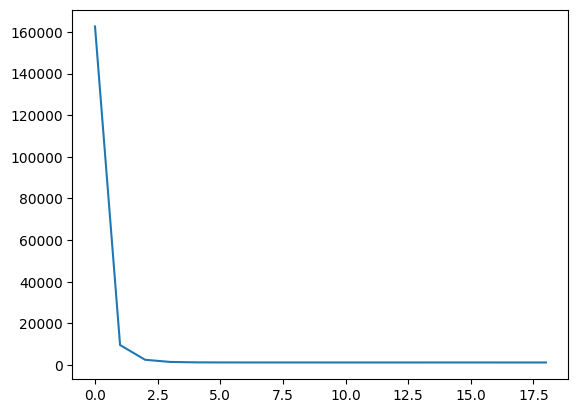

In [49]:
plt.plot(ias_data["obj_vals"])
plt.show()

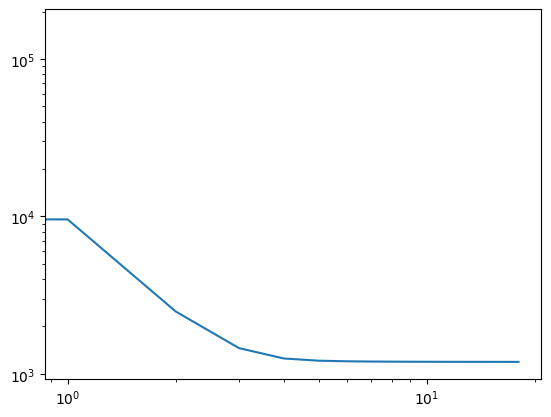

In [50]:
plt.loglog(ias_data["obj_vals"])
plt.show()

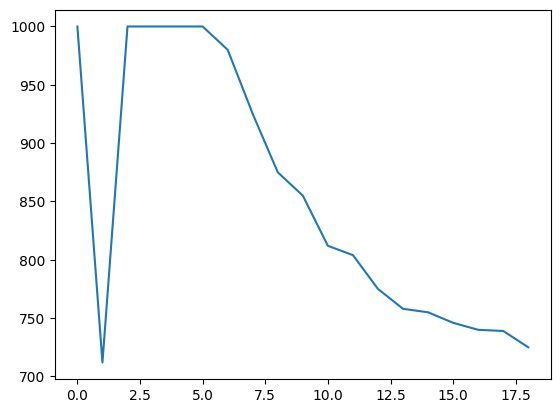

In [51]:
plt.plot(ias_data["n_cg_its_per_iteration"])
plt.show()

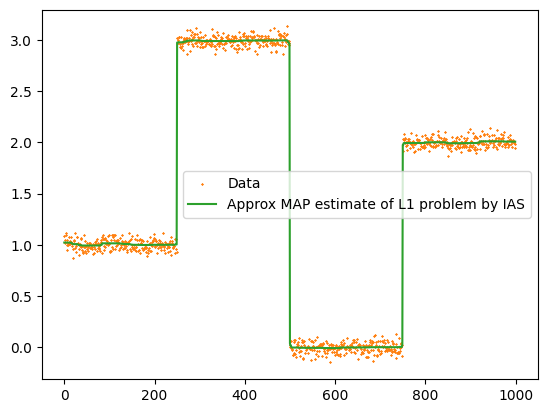

In [53]:
plt.scatter(grid, noisy_signal, marker="x", label="Data", color="C1", alpha=1.0, s=0.5)
plt.plot(grid, ias_data["x"], label="Approx MAP estimate of L1 problem by IAS", color="C2")
plt.legend()
plt.show()

In [54]:
err = np.linalg.norm(ias_data["x"] - fdgp_map_result)
print(err)

0.031859756474333166


# Now do for a sequence of eta

In [55]:
etas = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]
errs = []
sols = []
init = None
sols
for eta in etas:
    # Prior parameters
    hyperparams = {
        "prior": {
            "r": 1.0,
            "beta": 1.5 + eta,
            "vartheta": 2/(reg_lambda**2), # This is how to match the L1 lambda
        }
    }

    # Create solver
    ias_solver = sampi.IASSolver(F, R, noisy_signal, hyperparams, noise_var=noise_var, pdata=pdata)
    
    ias_data = ias_solver.solve(max_iters=200, 
                            early_stopping=False, 
                            warmstarting=True, 
                            eps=1e-3,
                           x_update_solver_params={"tol":1e-5},
                           )
    
    sol = ias_data["x"]
    sols.append(sol.copy())
    init = sol.copy()
    err = np.linalg.norm(sol - fdgp_map_result)
    errs.append(err)

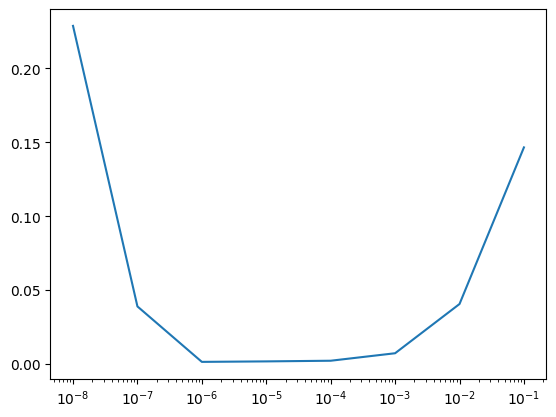

In [56]:
# plot erros
plt.semilogx(etas, errs)
plt.show()

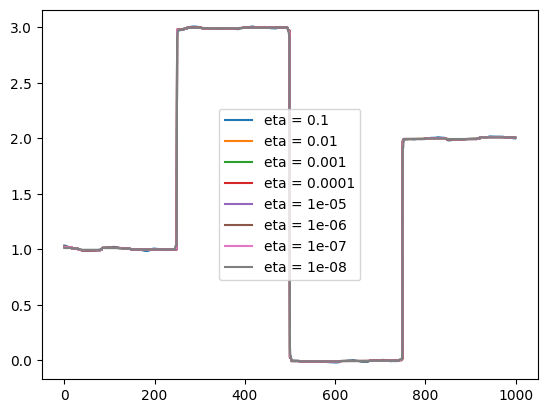

In [57]:
for j, eta in enumerate(etas):
    plt.plot(sols[j], label=f"eta = {eta}")
plt.legend()
plt.show()